In [1]:
import pandas as pd
import datetime as dt
import swifter
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import csv

In [60]:
f='/home/wmnlab/switch_band_test/2/udp_uplk_combo_loss_latency.csv'
df=pd.read_csv(f)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

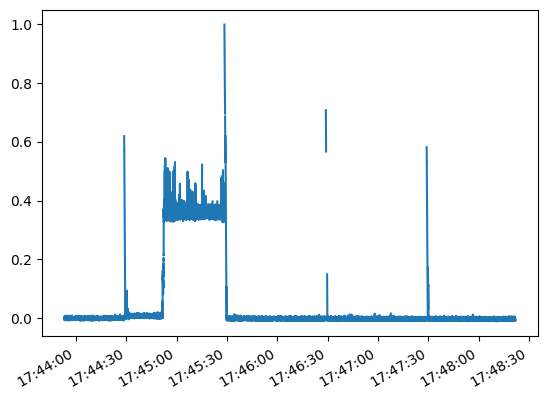

In [63]:
# plt.plot(df['Timestamp'],df['latency.qc00.qc01'])
# plt.plot(df['Timestamp'], df['latency.qc00'])
plt.plot(df['Timestamp'], df['latency.qc01'])
plt.gcf().autofmt_xdate()

In [113]:
def parse_mi_ho(df):
    def NR_OTA():
        if df["type_id"].iloc[i] == "5G_NR_RRC_OTA_Packet":
            return True
        else:
            return False

    def find_1st_after(target, look_after=1):
        for j in range(i, len(df)):
            t_ = df["time"].iloc[j]
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0']:
                return t_, j

    def find_1st_before(target, look_before=1):
        for j in range(i, -1, -1):
            t_ = df["time"].iloc[j]
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0']:
                return t_, j

    HO = namedtuple('HO','start, end, others', defaults=(None,None))

    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR
        # 'HOF': [], # Didn't defined yet.
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        }

    for i in range(len(df)):
        if NR_OTA():
            continue

        t = df["time"].iloc[i]
        
        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))

        if df["rrcConnectionRequest"].iloc[i] == 1:
            a = find_1st_after('rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after('securityModeComplete',look_after=2)[0]
            end = a if a > b else b
            D['Conn_Req'].append(HO(start=t,end=end))
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], df['lte_targetPhysCellId'].iloc[i]
            serv_freq, target_freq = df["Freq"].iloc[i], df['dl-CarrierFreq'].iloc[i]
            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others=f'Set up {n} SCell.'
            else:
                others=None
            
            if serv_freq != target_freq:
                others += " Inter freq. HO"
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['eNB_to_ENDC'].append(HO(start=t, end=end, others=others))
                    # print(1, t, f"Serving Cell: {serv_cell}->{target_cell}")  
                else:    
                    D['MN_HO'].append(HO(start=t, end=end, others=others))
            else:
                if serv_cell == target_cell and serv_freq == target_freq:
                    a, b = find_1st_before("scgFailureInformationNR-r15")
                    if a is not None:
                        others += "Caused by scg-failure."
                    D['gNB_Rel'].append(HO(start=t, end=end, others=others))
                else:
                    D['LTE_HO'].append(HO(start=t, end=end, others=others))

        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReconfigurationComplete')
            D['gNB_HO'].append(HO(start=t,end=end))

        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after('rrcConnectionReestablishmentReject', look_after=1)
            others = df["reestablishmentCause"].iloc[i]
            if end is not None: 
                # Type II
                D['RLF_II'].append(HO(start=t,end=end,others=others))
            else: 
                # Type III
                D['RLF_III'].append(HO(start=t,end=b,others=others)) # End for Type III?
            
        if df["scgFailureInformationNR-r15"].iloc[i] == 1:
            others = df["failureType-r15"].iloc[i]
            D['SCG_RLF'].append(HO(start=t,others=others))
    
    return D

In [115]:
A = parse_mi_ho(df)

In [50]:
f1 = "/home/wmnlab/test1.csv"
f2 = "/home/wmnlab/test2.csv"
f3 = "/home/wmnlab/test3.csv"
df1 = pd.read_csv(f1)
df1["Timestamp"] = df1["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
df2 = pd.read_csv(f2)
df2["Timestamp"] = df2["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
df3 = pd.read_csv(f3)
df3["Timestamp"] = df3["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))

In [51]:
a = list(df1["lat"])
b = list(df3["lat"])
# c = 

In [100]:
def correlations(a, b):
    length = len(a) if len(a)<len(b) else len(b)
    if length == len(a):
        return np.corrcoef(a,b[:len(a)])
    else:
        return np.corrcoef(a[:len(b)],b)

def gps_leg_corres(a, b, search=30): 
    corres = []
    legs = list(range(-search,search+1))
    for i in range(-search,search+1):
        if i<0:
            corres.append(correlations(a[-i:], b[:])[0,1])
        else:
            corres.append(correlations(a[:], b[i:])[0,1])
    index_max = max(range(len(corres)), key=corres.__getitem__)

    return legs[index_max]


In [101]:
x = gps_leg_corres(a,b)

In [103]:
if x < 0:
    x1 = list(df1["DL-lat"].iloc[-x:])
    x2 = list(df3["DL-lat"].iloc[:])
else:
    x1 = list(df1["DL-lat"].iloc[:])
    x2 = list(df3["DL-lat"].iloc[x:])

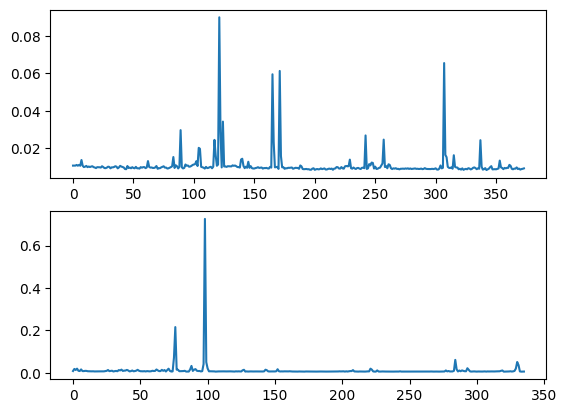

In [109]:
fig, axs = plt.subplots(2,1)
axs[0].plot(df1["DL-lat"].iloc[:])
axs[1].plot(df3["DL-lat"].iloc[:])

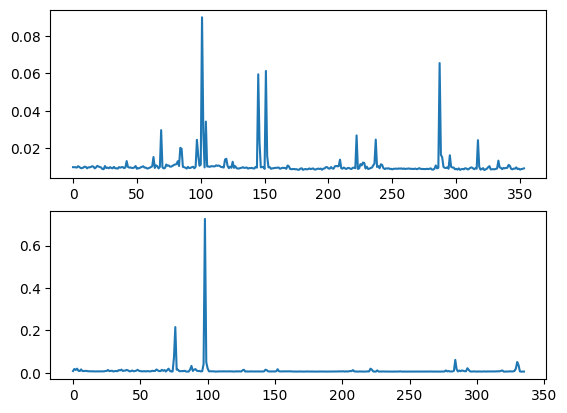

In [108]:
fig, axs = plt.subplots(2,1)
axs[0].plot(x1)
axs[1].plot(x2)